In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model


In [2]:
# Define a custom accuracy metric
def accuracy(y_true, y_pred):
    threshold = 0.1
    diff = tf.abs(y_true - y_pred)
    correct = tf.cast(diff < threshold, tf.float32)
    accuracy = tf.reduce_mean(correct)
    return accuracy



In [3]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()


In [4]:
# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [5]:
# Reshape data to fit the network input
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [6]:
# Introduce noise in the dataset
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)



In [7]:
# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [8]:
# Define the convolutional autoencoder model
input_img = Input(shape=(28, 28, 1))


In [9]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[accuracy])
autoencoder.summary()





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248

In [10]:
# Train the convolutional autoencoder
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs = 200,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))


Epoch 1/200


235/235 [==============================] - 28s 112ms/step - loss: 0.2169 - accuracy: 0.6559 - val_loss: 0.1333 - val_accuracy: 0.8093
Epoch 2/200
235/235 [==============================] - 26s 109ms/step - loss: 0.1258 - accuracy: 0.8275 - val_loss: 0.1200 - val_accuracy: 0.8429
Epoch 3/200
235/235 [==============================] - 26s 111ms/step - loss: 0.1170 - accuracy: 0.8466 - val_loss: 0.1137 - val_accuracy: 0.8506
Epoch 4/200
235/235 [==============================] - 27s 115ms/step - loss: 0.1126 - accuracy: 0.8560 - val_loss: 0.1110 - val_accuracy: 0.8614
Epoch 5/200
235/235 [==============================] - 28s 120ms/step - loss: 0.1099 - accuracy: 0.8618 - val_loss: 0.1081 - val_accuracy: 0.8651
Epoch 6/200
235/235 [==============================] - 28s 120ms/step - loss: 0.1077 - accuracy: 0.8661 - val_loss: 0.1058 - val_accuracy: 0.8693
Epoch 7/200
235/235 [==============================] - 29s 123ms/step - loss: 0.1061 - accuracy: 0.8692 - val_loss: 0.1045

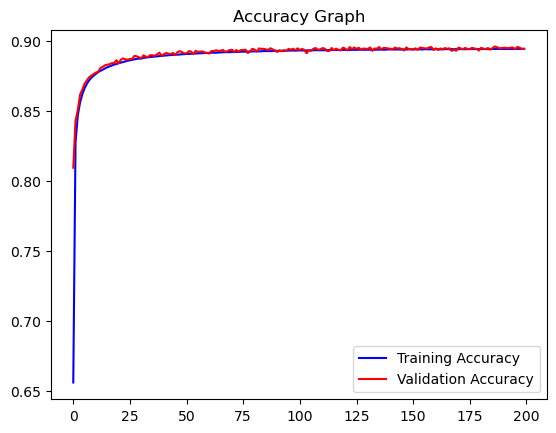

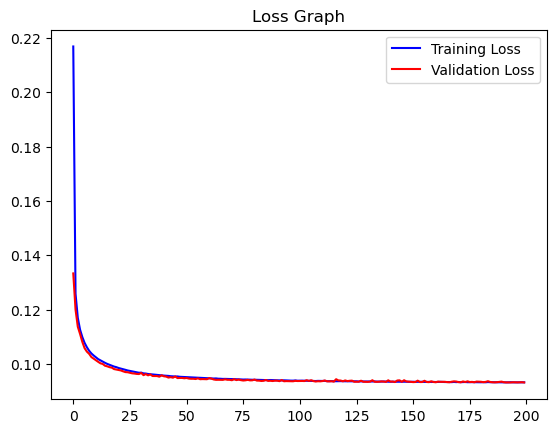

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc, 'b' ,label='Training Accuracy')
plt.plot(epochs,val_acc, 'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss, 'b' ,label='Training Loss')
plt.plot(epochs,val_loss, 'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [11]:
# Predict denoised images
x_test_denoised = autoencoder.predict(x_test_noisy)


313/313 [==============================] - 2s 5ms/step


In [12]:
# Function to plot original, noisy, and denoised images
def plot_images(original, noisy, denoised, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="binary")
        plt.title("Original")
        plt.axis("off")

        # Display noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].reshape(28, 28), cmap="binary")
        plt.title("Noisy")
        plt.axis("off")

        # Display denoised
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].reshape(28, 28), cmap="binary")
        plt.title("Denoised")
        plt.axis("off")
    plt.show()


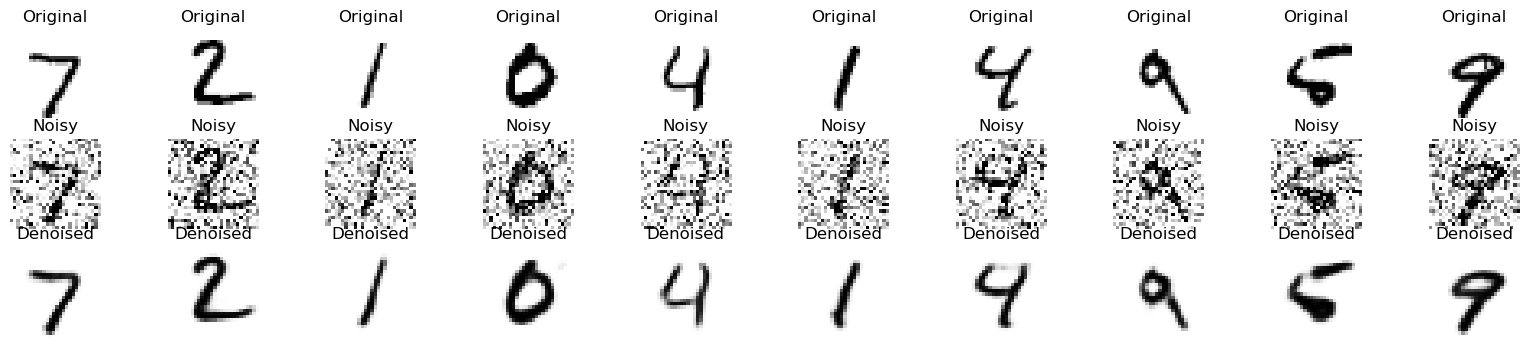

In [13]:
# Plot the original, noisy, and denoised images
plot_images(x_test, x_test_noisy, x_test_denoised)


In [14]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test - x_test_denoised), axis=(1, 2, 3))



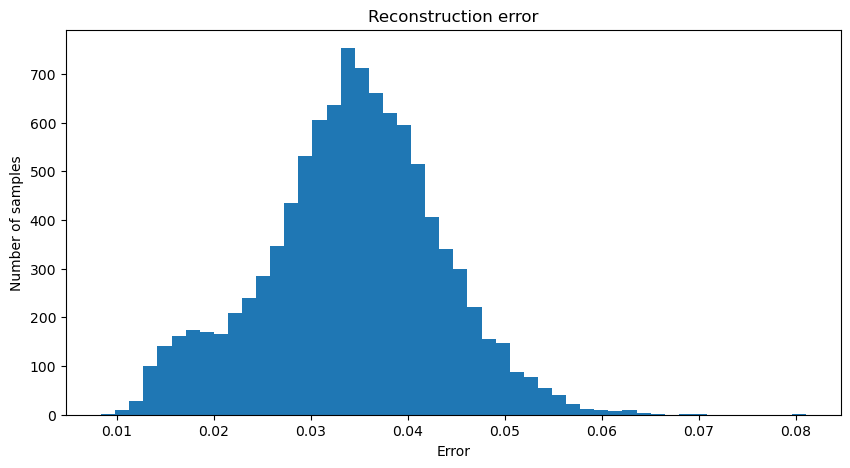

In [15]:
# Plot reconstruction error
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50)
plt.title("Reconstruction error")
plt.xlabel("Error")
plt.ylabel("Number of samples")
plt.show()


In [16]:
# Set a threshold for outliers based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # For example, 95th percentile
outliers = reconstruction_error > threshold


In [17]:
# Print the number of outliers detected
print(f"Number of outliers detected: {np.sum(outliers)}")



Number of outliers detected: 500


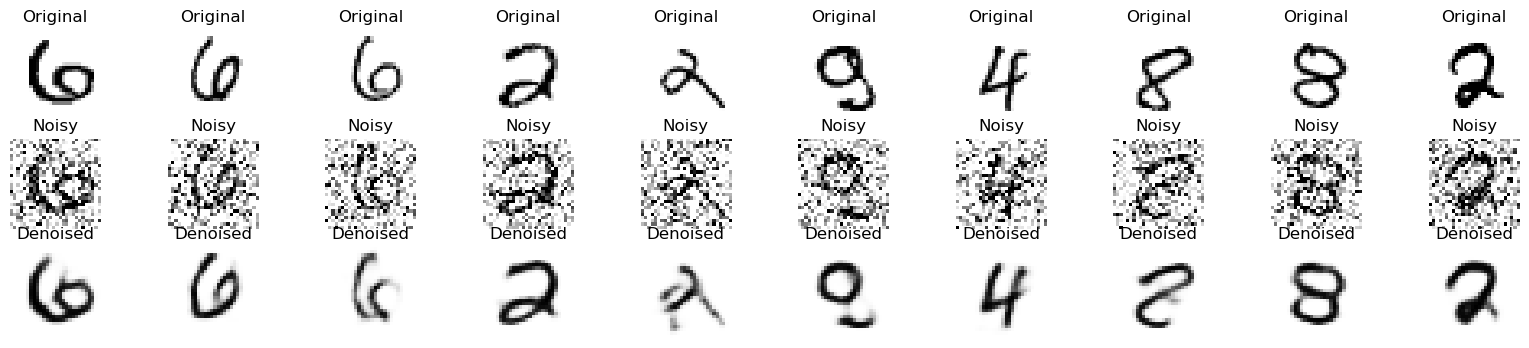

In [18]:
plot_images(x_test[outliers][:10], x_test_noisy[outliers][:10], x_test_denoised[outliers][:10], n=10)


In [19]:
# Calculate reconstruction error
reconstruction_error = np.mean(np.abs(x_test - x_test_denoised), axis=(1, 2, 3))

# Set a threshold for outliers based on reconstruction error (95th percentile)
threshold = np.percentile(reconstruction_error, 95)


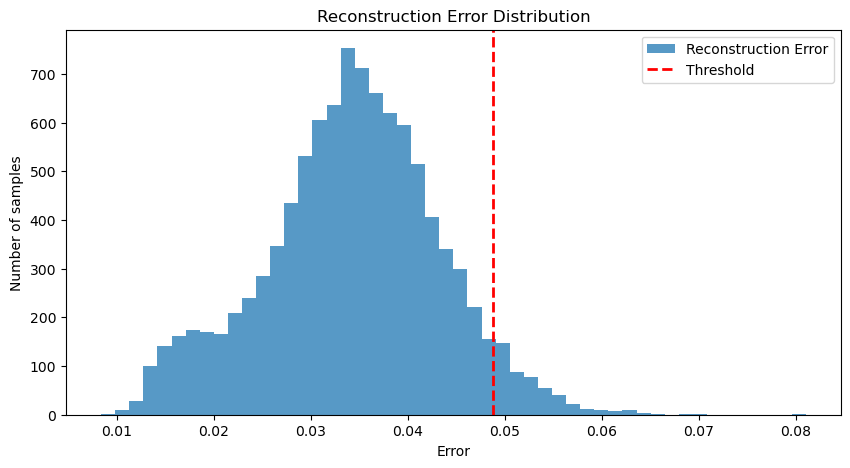

In [20]:
# Plot the reconstruction error distribution
def plot_reconstruction_error(reconstruction_error, threshold):
    plt.figure(figsize=(10, 5))
    plt.hist(reconstruction_error, bins=50, alpha=0.75, label='Reconstruction Error')
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Number of samples')
    plt.legend(loc='upper right')
    plt.show()

plot_reconstruction_error(reconstruction_error, threshold)


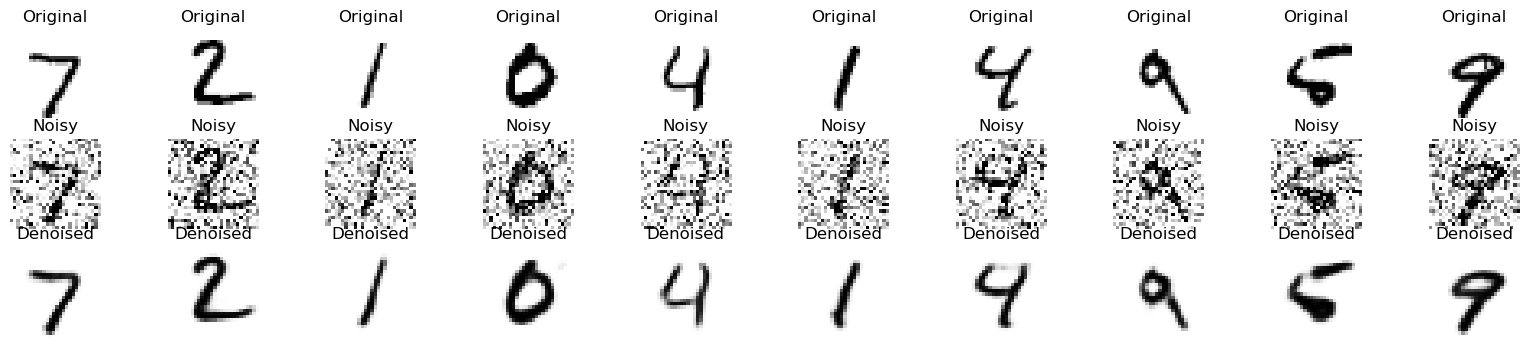

In [21]:
# Plot some sample images
plot_images(x_test, x_test_noisy, x_test_denoised)


313/313 [==============================] - 2s 5ms/step


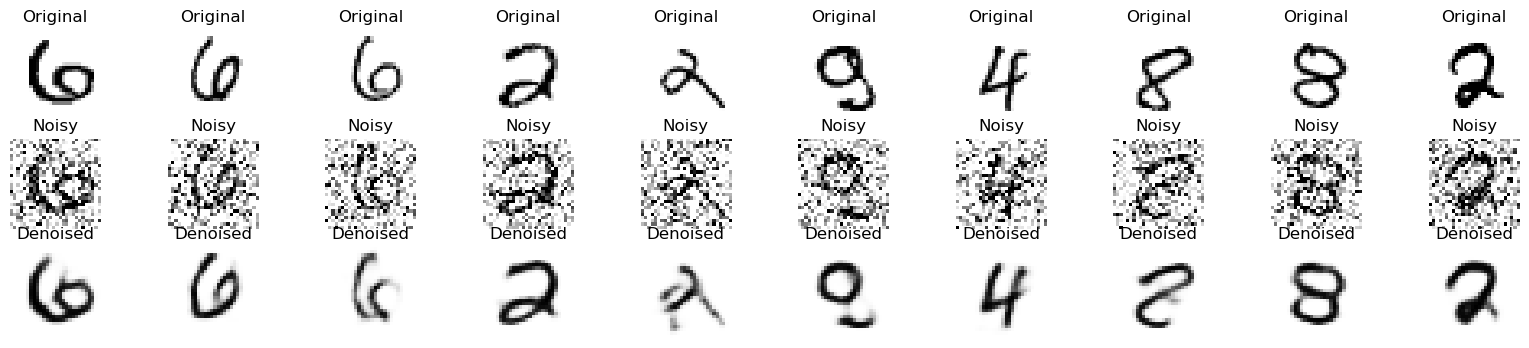

In [22]:
# Detect outliers
outliers = reconstruction_error > threshold

# Denoise the test images
x_test_denoised = autoencoder.predict(x_test_noisy)

# Plot some outliers
plot_images(x_test[outliers][:10], x_test_noisy[outliers][:10], x_test_denoised[outliers][:10], n=10)

In [28]:
# Detect noisy images
reconstructions = autoencoder.predict(x_test_noisy)
mse = np.mean(np.power(x_test_noisy - reconstructions, 2), axis=(1, 2,3))

313/313 [==============================] - 2s 5ms/step


In [29]:
# Set a threshold for noisy images
threshold = np.percentile(mse, 95)  # 95th percentile of MSE
noisy_images = mse > threshold

In [30]:
# Filter out noisy images
clean_images = x_test[~noisy_images]

In [31]:
# Function to display a list of images
def plot_images(images, nrows, ncols, cmap='gray'):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].reshape(28, 28), cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

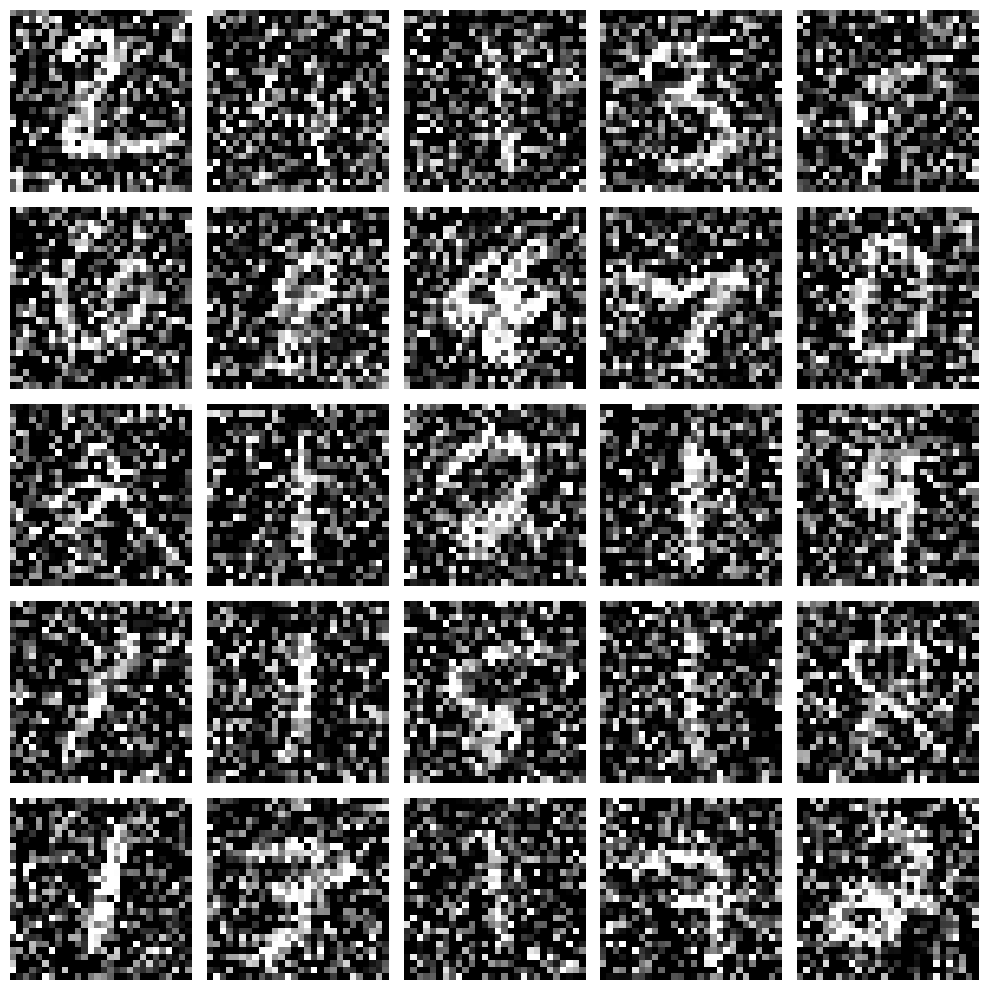

In [33]:
#Display original noisy images
plot_images(x_test_noisy[noisy_images][:25], 5, 5)

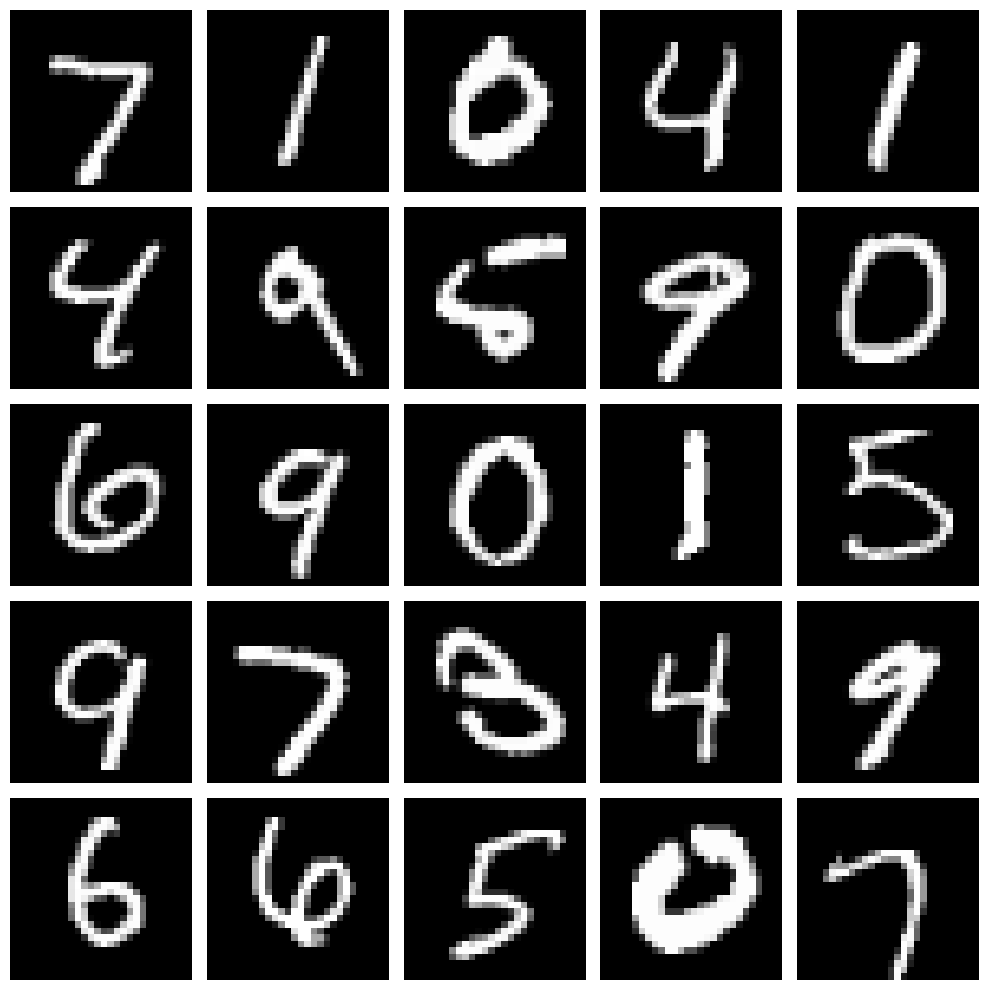

In [34]:
# Display clean images after removing noisy ones
plot_images(clean_images[:25], 5, 5)